We can define the LP as follows. $n$ is the length of the grid, and $s$ is the length of a sub-square within the grid. For instance, if $n = 9$, $s = 3$.

\begin{alignat*}{3}
\sum_{i, j}^{n} x_{ijv} = 1 \\
\sum_{i, v}^{n} x_{ijv} = 1 \\
\sum_{j, v}^{n} x_{ijv} = 1 \\
\sum_{i=si'}^{s(i'+1)} \sum_{j=sj'}^{s(j'+1)} x_{ijv} = 1 \\
i, j, v \in [1, n] \\
i', j' \in [1, s] \\
x_{ijv} \in [0, 1]
\end{alignat*}

Linear Relaxation:

\begin{alignat*}{3}
\sum_{i, j}^{n} x_{ijv} = 1 \\
\sum_{i, v}^{n} x_{ijv} = 1 \\
\sum_{j, v}^{n} x_{ijv} = 1 \\
\sum_{i=si'}^{s(i'+1)} \sum_{j=sj'}^{s(j'+1)} x_{ijv} = 1 \\
i, j, v \in [1, n] \\
i', j' \in [1, s] \\
0 \leq x_{ijv} \leq 1 
\end{alignat*}

In [1]:
import random
import copy
import time
import os
import gurobipy as gp
from gurobipy import GRB, quicksum, max_, abs_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def create_empty_grid(size=9):
    #0 = "empty"
    return np.zeros((size,size))

In [4]:
def load_test():
    grid = create_empty_grid(9)

    grid[0][1]=2
    grid[0][4]=3
    grid[0][7]=4
    grid[1][0]=6
    grid[1][8]=3
    grid[2][2]=4
    grid[2][6]=5
    grid[3][3]=8
    grid[3][5]=6
    grid[4][0]=8
    grid[4][4]=1
    grid[4][8]=6
    grid[5][3]=7
    grid[5][5]=5
    grid[6][2]=7
    grid[6][6]=6
    grid[7][0]=4
    grid[7][8]=8
    grid[8][1]=3
    grid[8][4]=4
    grid[8][7]=2

    return grid

In [5]:
def print_solution(grid, model, variables):
    print('')
    print('Solution:')
    print('')
    n = len(grid[0])
    s = int(n**0.5)

    # Retrieve optimization result

    solution = model.getAttr('X', variables)

    for i in range(n):
        sol = ''
        if i != 0 and i % s == 0:
            sol += '\n'
        for j in range(n):
            if j != 0 and j % s == 0:
                sol += '  '
            for v in range(n):
                if solution[i, j, v] > 0.5:
                    sol += str(v+1)
        print(sol)

def print_solution2(grid, model, variables, si, sj):
    print('')
    print('Solution:')
    print('')
    n = len(grid[0])

    # Retrieve optimization result

    solution = model.getAttr('X', variables)

    for i in range(n):
        sol = ''
        if i != 0 and i % sj == 0:
            sol += '\n'
        for j in range(n):
            if j != 0 and j % si == 0:
                sol += '  '
            for v in range(n):
                if solution[i, j, v] > 0.5:
                    sol += str(v+1).rjust(n//10 + 2)
        print(sol)

In [618]:
def gurobi_solution(grid, binary=True):
# In the MIP formulation, binary variables x[i,j,v] indicate whether
# cell <i,j> takes value 'v'.  The constraints are as follows:
#   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
#   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
#   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
#   4. Each value is used exactly once per 3x3 subgrid (sum_grid x[i,j,v] = 1)

    n = len(grid[0])
    s = int(n**0.5)
    model = gp.Model('gurobi')
    model.Params.LogToConsole = 0
    type = GRB.BINARY if binary else GRB.CONTINUOUS
    var = model.addVars(n, n, n, vtype=type, name='G')

#     model.setObjective(var.sum(), GRB.MINIMIZE)

    # Fix variables associated with cells whose values are pre-specified
    for i in range(n):
        for j in range(n):
            if grid[i][j] > 0:
                v = int(grid[i][j]) - 1
                var[i, j, v].LB = 1


    # Each cell must take one value
    model.addConstrs((var.sum(r, c, '*') == 1
                     for r in range(n)
                     for c in range(n)), name='V')


    # Each value appears once per row
    model.addConstrs((var.sum(r, '*', v) == 1
                     for r in range(n)
                     for v in range(n)), name='R')


    # Each value appears once per column
    model.addConstrs((var.sum('*', c, v) == 1
                     for c in range(n)
                     for v in range(n)), name='C')


    # Each value appears once per subgrid
    model.addConstrs((
        gp.quicksum(var[i, j, v] for i in range(i0*s, (i0+1)*s)
                    for j in range(j0*s, (j0+1)*s)) == 1
        for v in range(n)
        for i0 in range(s)
        for j0 in range(s)), name='Sub')

    model.optimize()

    return model, var

In [7]:
def gridtest2():
    grid = np.zeros((12,12))
    grid[1][0] = 2
    grid[1][1] = 12
    grid[1][10] = 7
    grid[2][1] = 3
    grid[3][1] = 5
    grid[4][2] = 4
    grid[5][2] = 9
    grid[7][0] = 6
    grid[8][1] = 8
    grid[8][2] = 2
    grid[8][3] = 5
    grid[9][0] = 12
    grid[9][1] = 4
    grid[9][2] = 7
    grid[10][1] = 10
    grid[11][0] = 1
    grid[11][2] = 5
    
    grid[1][5] = 4
    grid[1][7] = 9
    grid[2][4] = 1
    grid[2][5] = 7
    grid[2][6] = 6
    grid[3][7] = 11
    grid[4][4] = 6
    grid[4][7] = 5
    grid[5][5] = 2
    grid[5][6] = 8
    grid[6][5] = 10
    grid[6][6] = 7
    grid[7][4] = 8
    grid[7][7] = 12
    grid[8][4] = 3
    grid[9][5] = 3
    grid[9][6] = 9
    grid[9][7] = 1
    grid[10][4] = 12
    grid[10][6] = 2
    
    grid[0][9] = 1
    grid[0][11] = 9
    grid[1][10] = 7
    grid[2][9] = 12
    grid[2][10] = 10
    grid[2][11] = 11
    grid[3][8] = 8
    grid[3][9] = 6
    grid[3][10] = 2
    grid[4][11] = 1
    grid[6][9] = 8
    grid[7][9] = 3
    grid[8][10] = 12
    grid[9][10] = 5
    grid[10][10] = 1
    grid[10][11] = 3
    
    return grid

In [617]:
def gurobi_solution2(grid, si, sj, sols=1, binary=True):
# In the MIP formulation, binary variables x[i,j,v] indicate whether
# cell <i,j> takes value 'v'.  The constraints are as follows:
#   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
#   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
#   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
#   4. Each value is used exactly once per 3x3 subgrid (sum_grid x[i,j,v] = 1)

    n = len(grid[0])
    model = gp.Model('gurobi')
#     model.Params.LogToConsole = 0
    if sols > 1:
#         model.Params.LogToConsole = 0
        model.params.OutputFlag = 0
        model.Params.PoolSolutions = sols
        model.Params.PoolSearchMode = 2
    type = GRB.BINARY if binary else GRB.CONTINUOUS
    var = model.addVars(n, n, n, vtype=type, name='G')

#     model.setObjective(var.sum(), GRB.MINIMIZE)

    # Fix variables associated with cells whose values are pre-specified
    for i in range(n):
        for j in range(n):
            if grid[i][j] > 0:
                v = int(grid[i][j]) - 1
                var[i, j, v].LB = 1


    # Each cell must take one value
    model.addConstrs((var.sum(r, c, '*') == 1
                     for r in range(n)
                     for c in range(n)), name='V')


    # Each value appears once per row
    model.addConstrs((var.sum(r, '*', v) == 1
                     for r in range(n)
                     for v in range(n)), name='R')


    # Each value appears once per column
    model.addConstrs((var.sum('*', c, v) == 1
                     for c in range(n)
                     for v in range(n)), name='C')


    # Each value appears once per subgrid
    model.addConstrs((
        gp.quicksum(var[i, j, v] for i in range(i0*sj, (i0+1)*sj)
                    for j in range(j0*si, (j0+1)*si)) == 1
        for v in range(n)
        for i0 in range(si)
        for j0 in range(sj)), name='Sub')

    model.optimize()
    
    solution = np.zeros((n,n))
    sol = model.getAttr('X', var)
    for i in range(n):
        for j in range(n):
            for v in range(n):
                if sol[i, j, v] > 0.5:
                    solution[i][j] = v + 1

    return model, var, solution, model.SolCount

In [574]:

grid = load_test()
mdl, var = gurobi_solution(grid)
print_solution(grid, mdl, var)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 324 rows, 729 columns and 2916 nonzeros
Model fingerprint: 0x89c5faa8
Variable types: 0 continuous, 729 integer (729 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 324 rows and 729 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

Solution:

925  631  847
618  574  293
374  982  561

749  826  135
852  413  976
163  795  482

287  359  614
491  267  358
536  148  729


In [575]:
grid = gridtest2()
mdl, var, solution, cnt = gurobi_solution2(grid, 4, 3)
print_solution2(grid, mdl, var, 4, 3)

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0xe4760374
Variable types: 0 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 576 rows and 1728 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%

Solution:

 10  7 11  4    5  8 12  3    2  1  6  9
  2 12  1  6   10  4 11  9    3  5  7  8
  5  3  8  9    1  7  6  2    4 12 10 11

  7  5 12 10    9  1  3 11    8  6  2  4
  8 11  4  2    6 12 10  5    9  7  3  1
  3  6  9  1    4  2  8  7   12 10 11  5

 11  1  3 12    2 10  7

In [11]:
def is_used(grid, row, col, num):
    if in_row(grid, row, num):
        return True
    elif in_col(grid, col, num):
        return True
    elif in_mini(grid, row, col, num):
        return True
    return False
    

def in_row(grid, row, num):
    return num in grid[row]


def in_col(grid, col, num):
    size = len(grid[0])
    col_list = [grid[r][col] for r in range(size)]
    return num in col_list


def get_mini_list(grid, row, col):
    size = len(grid[0])
    root = int(size**0.5)
    mini_row = root*(row // root)
    mini_row2 = mini_row + root
    mini_col = root*(col // root)
    mini_col2 = mini_col + root
    mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
    return mini_list


def in_mini(grid, row, col, num):
    return num in get_mini_list(grid, row, col)


def has_zeroes(grid):
    size = len(grid[0])
    for row in range(size):
        if 0 in grid[row]:
            return True
    return False

def count_occurances(grid, num=0):
    return sum(cell == num for row in grid for cell in row)

In [12]:
def generate_grid(size=9):
    if(size**0.5 != int(size**0.5)):
        raise ValueError("Size must be a perfect square")
    grid = create_empty_grid(size)
    fill_grid(grid)
    return grid


def fill_grid(grid, solve=False):
    global solver_counter
    size = len(grid[0])
    squared = size**2
    numbers = [temp+1 for temp in range(size)]
    for i in range(0, squared):
        row = i // size
        col = i % size
        if grid[row][col] != 0:
            continue
        if not solve:
            random.shuffle(numbers)
        for num in numbers:
            if not is_used(grid, row, col, num):
                grid[row][col] = num
                if not has_zeroes(grid):
                    solver_counter += 1
                    if solve:
                        break
                    return True
                elif fill_grid(grid, solve):
                    return True
        break
    grid[row][col] = 0


In [13]:
def sparsify(grid, attempts=5):
    # larger number of attempts = the more sparse it gets
    # Warning this could go for awhile!
    global solver_counter
    size = len(grid[0])
    original = copy.deepcopy(grid)
    while attempts > 0:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        
        backup = grid[row][col]
        grid[row][col] = 0
        test_grid = copy.deepcopy(grid)

        solver_counter = 0
        fill_grid(test_grid, True)

        if solver_counter != 1:
            grid[row][col] = backup
            attempts -= 1
            print("DECREMENTING ATTEMPTS {} - solver_counter={}".format(attempts, solver_counter))
    return original, grid


def sparsify_no_check(grid, num_clues=None):
    size = len(grid[0])
    clues = num_clues or (size**2 // 4) # just a good speculation
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    original = copy.deepcopy(grid)
    remaining = size**2
    while remaining > clues:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        grid[row][col] = 0
        remaining -= 1
    return original, grid

In [14]:
def is_used(grid, si, sj, row, col, num):
    if in_row(grid, row, num):
        return True
    elif in_col(grid, col, num):
        return True
    elif in_mini(grid, si, sj, row, col, num):
        return True
    return False
    

def in_row(grid, row, num):
    return num in grid[row]


def in_col(grid, col, num):
    size = len(grid[0])
    col_list = [grid[r][col] for r in range(size)]
    return num in col_list


def get_mini_list(grid, si, sj, row, col):
    size = len(grid[0])
    root = int(size**0.5)
    mini_row = sj*(row // sj)
    mini_row2 = mini_row + sj
    mini_col = si*(col // si)
    mini_col2 = mini_col + si
    mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
    return mini_list


def in_mini(grid, si, sj, row, col, num):
    return num in get_mini_list(grid, si, sj, row, col)


def has_zeroes(grid):
    size = len(grid[0])
    for row in range(size):
        if 0 in grid[row]:
            return True
    return False


def count_occurances(grid, num=0):
    return sum(cell == num for row in grid for cell in row)

In [15]:
global solver_counter
solver_counter = 0

def generate_grid(size=9, si=None, sj=None):
    if(si is None and sj is None):
        if(size**0.5 != int(size**0.5)):
            raise ValueError("Size must be a perfect square, or smaller subgrid dimensions need to be provided")
        si = int(size**0.5)
        sj = int(size**0.5)
    grid = create_empty_grid(size)
    fill_grid(grid, si, sj)
    return grid


def fill_grid(grid, si, sj, solve=False):
    global solver_counter
    size = len(grid[0])
    squared = size**2
    numbers = [temp+1 for temp in range(size)]
    for i in range(0, squared):
        row = i // size
        col = i % size
        if grid[row][col] != 0:
            continue
        if not solve:
            random.shuffle(numbers)
        for num in numbers:
            if not is_used(grid, si, sj, row, col, num):
                grid[row][col] = num
                if not has_zeroes(grid):
                    solver_counter += 1
                    if solve:
                        break
                    return True
                elif fill_grid(grid, si, sj, solve):
                    return True
        break
    grid[row][col] = 0

def sparsify(grid, si, sj, attempts=5):
    # larger number of attempts = the more sparse it gets
    # Warning this could go for awhile!
    global solver_counter
    size = len(grid[0])
    original = copy.deepcopy(grid)
    while attempts > 0:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        
        backup = grid[row][col]
        grid[row][col] = 0
        test_grid = copy.deepcopy(grid)

        solver_counter = 0
        fill_grid(test_grid, si, sj, True)

        if solver_counter != 1:
            grid[row][col] = backup
            attempts -= 1
            print("DECREMENTING ATTEMPTS {} - solver_counter={}".format(attempts, solver_counter))
    return original, grid


def sparsify_no_check(grid, si, sj, num_clues=None):
    size = len(grid[0])
    clues = num_clues or (size**2 // 4) # just a good speculation
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    original = copy.deepcopy(grid)
    remaining = size**2
    while remaining > clues:
        row = random.randint(0, size-1)
        col = random.randint(0, size-1)
        while grid[row][col] == 0:
            row = random.randint(0, size-1)
            col = random.randint(0, size-1)
        grid[row][col] = 0
        remaining -= 1
    return original, grid

In [16]:
def sparsify3(g, si, sj, num_clues=0, validate=True):
    original = copy.deepcopy(g)
    grid = copy.deepcopy(g)
    n = len(grid[0])
    remaining = n**2
    clues = num_clues or (n**2 // 4) # just a good speculation
    max_iter = int(n**2.5)
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 12x12 min = 30   (size**2 // 4 == 36)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    row = random.randint(1, n) - 1
    col = random.randint(1, n) - 1
    iteration = -1
    stats = []
    while remaining > clues and iteration < max_iter:
        iteration += 1
        x = 0
        while not x:
            row = random.randint(1, n) - 1
            col = random.randint(1, n) - 1
            x = grid[row][col]
        orig_val = grid[row][col]
        grid[row][col] = 0
        remaining -= 1
        if validate:
            m, v, sol, cnt = gurobi_solution2(grid, si, sj, sols=2)
            print(f"iter {str(iteration).rjust(4)}/{max_iter}  grid[{str(row).rjust(2)}][{str(col).rjust(2)}] = {orig_val}  sol_cnt = {cnt}  rem = {remaining}  soltime = {m.Runtime}")
            stats.append({
                "clues": clues,
                "max_iter": max_iter,
                "iter": iteration,
                "remaining": remaining,
                "row": row,
                "col": col,
                "orig_val": orig_val,
                "sol_cnt": cnt,
                "runtime": m.Runtime
            })
            if cnt != 1: # 0 = not solvable, 2 = too many
                grid[row][col] = orig_val
                remaining += 1
    return original, grid, stats

In [17]:

test = np.zeros((12,12))
fill_grid(test, 4, 3)
original = copy.deepcopy(test)
grid = copy.deepcopy(original)
o, g, stats = sparsify3(grid, 4, 3)

iter    0/498  grid[ 5][ 1] = 2.0  sol_cnt = 1  rem = 143  soltime = 0.0011148452758789062
iter    1/498  grid[ 4][ 2] = 9.0  sol_cnt = 1  rem = 142  soltime = 0.0010268688201904297
iter    2/498  grid[ 6][ 0] = 12.0  sol_cnt = 1  rem = 141  soltime = 0.0010800361633300781
iter    3/498  grid[ 3][ 0] = 3.0  sol_cnt = 1  rem = 140  soltime = 0.0009241104125976562
iter    4/498  grid[ 0][ 0] = 11.0  sol_cnt = 1  rem = 139  soltime = 0.0014159679412841797
iter    5/498  grid[ 8][ 7] = 11.0  sol_cnt = 1  rem = 138  soltime = 0.0009198188781738281
iter    6/498  grid[ 4][ 3] = 8.0  sol_cnt = 1  rem = 137  soltime = 0.0008668899536132812
iter    7/498  grid[11][ 6] = 7.0  sol_cnt = 1  rem = 136  soltime = 0.0008928775787353516
iter    8/498  grid[ 0][11] = 1.0  sol_cnt = 1  rem = 135  soltime = 0.0008330345153808594
iter    9/498  grid[ 5][ 4] = 10.0  sol_cnt = 1  rem = 134  soltime = 0.0010030269622802734
iter   10/498  grid[ 5][ 9] = 3.0  sol_cnt = 1  rem = 133  soltime = 0.000921964645385

iter   91/498  grid[ 2][ 4] = 1.0  sol_cnt = 2  rem = 55  soltime = 0.0029540061950683594
iter   92/498  grid[ 0][ 3] = 4.0  sol_cnt = 2  rem = 55  soltime = 0.0037240982055664062
iter   93/498  grid[11][ 5] = 10.0  sol_cnt = 2  rem = 55  soltime = 0.0031249523162841797
iter   94/498  grid[ 6][ 5] = 9.0  sol_cnt = 1  rem = 55  soltime = 0.0022470951080322266
iter   95/498  grid[ 0][ 3] = 4.0  sol_cnt = 2  rem = 54  soltime = 0.003720998764038086
iter   96/498  grid[ 2][ 1] = 3.0  sol_cnt = 1  rem = 54  soltime = 0.002457857131958008
iter   97/498  grid[10][ 8] = 6.0  sol_cnt = 2  rem = 53  soltime = 0.003446817398071289
iter   98/498  grid[ 9][ 0] = 6.0  sol_cnt = 2  rem = 53  soltime = 0.005173921585083008
iter   99/498  grid[ 0][ 3] = 4.0  sol_cnt = 2  rem = 53  soltime = 0.0033690929412841797
iter  100/498  grid[ 5][10] = 12.0  sol_cnt = 1  rem = 53  soltime = 0.0026209354400634766
iter  101/498  grid[ 1][ 7] = 12.0  sol_cnt = 2  rem = 52  soltime = 0.003493070602416992
iter  102/49

iter  184/498  grid[ 9][11] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.01458597183227539
iter  185/498  grid[ 6][ 8] = 10.0  sol_cnt = 2  rem = 46  soltime = 0.018923044204711914
iter  186/498  grid[ 2][10] = 11.0  sol_cnt = 2  rem = 46  soltime = 0.020368099212646484
iter  187/498  grid[ 0][ 9] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.0052928924560546875
iter  188/498  grid[ 7][ 6] = 6.0  sol_cnt = 2  rem = 46  soltime = 0.013202905654907227
iter  189/498  grid[ 4][ 5] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.011038064956665039
iter  190/498  grid[11][ 2] = 4.0  sol_cnt = 2  rem = 46  soltime = 0.013540983200073242
iter  191/498  grid[ 5][ 2] = 11.0  sol_cnt = 2  rem = 46  soltime = 0.012453079223632812
iter  192/498  grid[11][ 9] = 8.0  sol_cnt = 2  rem = 46  soltime = 0.004336118698120117
iter  193/498  grid[ 1][ 8] = 2.0  sol_cnt = 2  rem = 46  soltime = 0.0168612003326416
iter  194/498  grid[10][ 8] = 6.0  sol_cnt = 2  rem = 46  soltime = 0.010677099227905273
iter  195/498  gr

iter  277/498  grid[ 9][11] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.012984037399291992
iter  278/498  grid[11][ 9] = 8.0  sol_cnt = 2  rem = 46  soltime = 0.005068063735961914
iter  279/498  grid[ 1][ 3] = 7.0  sol_cnt = 2  rem = 46  soltime = 0.009920120239257812
iter  280/498  grid[ 3][ 6] = 1.0  sol_cnt = 2  rem = 46  soltime = 0.010764837265014648
iter  281/498  grid[ 9][11] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.012830972671508789
iter  282/498  grid[ 6][ 9] = 2.0  sol_cnt = 2  rem = 46  soltime = 0.01522517204284668
iter  283/498  grid[11][ 9] = 8.0  sol_cnt = 2  rem = 46  soltime = 0.005361080169677734
iter  284/498  grid[10][ 0] = 2.0  sol_cnt = 2  rem = 46  soltime = 0.011746883392333984
iter  285/498  grid[10][ 0] = 2.0  sol_cnt = 2  rem = 46  soltime = 0.013273954391479492
iter  286/498  grid[ 4][10] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.013641119003295898
iter  287/498  grid[ 2][11] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.013720035552978516
iter  288/498  grid[

iter  371/498  grid[ 9][ 0] = 6.0  sol_cnt = 2  rem = 46  soltime = 0.00972294807434082
iter  372/498  grid[ 2][10] = 11.0  sol_cnt = 2  rem = 46  soltime = 0.018641948699951172
iter  373/498  grid[ 2][11] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.012984991073608398
iter  374/498  grid[ 9][11] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.012276172637939453
iter  375/498  grid[ 6][ 8] = 10.0  sol_cnt = 2  rem = 46  soltime = 0.012284040451049805
iter  376/498  grid[ 6][ 4] = 7.0  sol_cnt = 2  rem = 46  soltime = 0.014757871627807617
iter  377/498  grid[10][ 4] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.012284994125366211
iter  378/498  grid[ 9][11] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.013190031051635742
iter  379/498  grid[ 9][ 0] = 6.0  sol_cnt = 2  rem = 46  soltime = 0.009361982345581055
iter  380/498  grid[ 3][ 1] = 7.0  sol_cnt = 2  rem = 46  soltime = 0.011404037475585938
iter  381/498  grid[ 2][ 4] = 1.0  sol_cnt = 2  rem = 46  soltime = 0.012333154678344727
iter  382/498  gri

iter  469/498  grid[ 1][ 7] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.011858940124511719
iter  470/498  grid[ 4][ 5] = 12.0  sol_cnt = 2  rem = 46  soltime = 0.010470867156982422
iter  471/498  grid[ 0][10] = 10.0  sol_cnt = 2  rem = 46  soltime = 0.011701822280883789
iter  472/498  grid[11][ 5] = 10.0  sol_cnt = 2  rem = 46  soltime = 0.013119220733642578
iter  473/498  grid[ 8][ 1] = 9.0  sol_cnt = 2  rem = 46  soltime = 0.008002042770385742
iter  474/498  grid[ 4][10] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.011004924774169922
iter  475/498  grid[ 3][ 6] = 1.0  sol_cnt = 2  rem = 46  soltime = 0.010649919509887695
iter  476/498  grid[10][10] = 9.0  sol_cnt = 2  rem = 46  soltime = 0.008536100387573242
iter  477/498  grid[10][ 4] = 5.0  sol_cnt = 2  rem = 46  soltime = 0.013663053512573242
iter  478/498  grid[10][ 8] = 6.0  sol_cnt = 2  rem = 46  soltime = 0.011476993560791016
iter  479/498  grid[11][ 2] = 4.0  sol_cnt = 2  rem = 46  soltime = 0.011872053146362305
iter  480/498  gr

In [18]:
o

array([[11.,  6.,  2.,  4.,  9.,  7.,  8.,  5.,  3., 12., 10.,  1.],
       [10.,  1.,  5.,  7.,  3.,  6., 11., 12.,  2.,  4.,  8.,  9.],
       [ 9.,  3.,  8., 12.,  1.,  2.,  4., 10.,  7.,  6., 11.,  5.],
       [ 3.,  7., 12.,  6., 11.,  5.,  1.,  8.,  9., 10.,  2.,  4.],
       [ 4., 10.,  9.,  8.,  2., 12.,  3.,  6.,  1., 11.,  5.,  7.],
       [ 1.,  2., 11.,  5., 10.,  4.,  9.,  7.,  8.,  3., 12.,  6.],
       [12.,  4.,  1., 11.,  7.,  9.,  5.,  3., 10.,  2.,  6.,  8.],
       [ 8.,  5.,  3., 10.,  4.,  1.,  6.,  2., 12.,  9.,  7., 11.],
       [ 7.,  9.,  6.,  2., 12.,  8., 10., 11.,  4.,  5.,  1.,  3.],
       [ 6., 11., 10.,  9.,  8.,  3.,  2.,  1.,  5.,  7.,  4., 12.],
       [ 2.,  8.,  7.,  3.,  5., 11., 12.,  4.,  6.,  1.,  9., 10.],
       [ 5., 12.,  4.,  1.,  6., 10.,  7.,  9., 11.,  8.,  3.,  2.]])

In [19]:
g

array([[ 0.,  0.,  2.,  4.,  0.,  0.,  8.,  0.,  3., 12., 10.,  0.],
       [ 0.,  0.,  0.,  7.,  3.,  0.,  0., 12.,  2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  7.,  0., 11.,  5.],
       [ 0.,  7.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  4.],
       [ 0., 10.,  0.,  0.,  0., 12.,  0.,  6.,  0.,  0.,  5.,  0.],
       [ 0.,  0., 11.,  0.,  0.,  0.,  9.,  7.,  8.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  7.,  0.,  0.,  0., 10.,  2.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  4.,  0.,  6.,  2.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 6.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 12.],
       [ 2.,  0.,  0.,  0.,  5.,  0.,  0.,  0.,  6.,  1.,  9.,  0.],
       [ 5.,  0.,  4.,  0.,  0., 10.,  0.,  0.,  0.,  8.,  0.,  0.]])

In [20]:
df = pd.DataFrame(stats)

In [21]:
df.describe()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime
count,499.0,499.0,499.000000,499.000000,499.000000,499.000000,499.00000,499.000000,499.000000
mean,36.0,498.0,249.000000,56.116232,5.360721,5.655311,6.49499,1.805611,0.010047
std,0.0,0.0,144.193157,22.835682,3.645173,3.381592,3.51038,0.396127,0.005406
min,36.0,498.0,0.000000,46.000000,0.000000,0.000000,1.00000,1.000000,0.000772
25%,36.0,498.0,124.500000,46.000000,2.000000,3.000000,3.50000,2.000000,0.005288
50%,36.0,498.0,249.000000,46.000000,5.000000,6.000000,7.00000,2.000000,0.011393
75%,36.0,498.0,373.500000,49.000000,9.000000,9.000000,9.00000,2.000000,0.012985
max,36.0,498.0,498.000000,143.000000,11.000000,11.000000,12.00000,2.000000,0.030560


In [22]:
df.columns

Index(['clues', 'max_iter', 'iter', 'remaining', 'row', 'col', 'orig_val',
       'sol_cnt', 'runtime'],
      dtype='object')

In [23]:
df[['remaining', 'runtime']].groupby('remaining').describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
46          319.0  0.012367  0.003397  0.004336  0.010931  0.011975  0.013495   
47            5.0  0.014496  0.008105  0.004061  0.008453  0.015938  0.020944   
48           36.0  0.012911  0.004747  0.004304  0.010423  0.011693  0.014822   
49           28.0  0.011004  0.003089  0.003811  0.009988  0.011140  0.012768   
50            3.0  0.007512  0.003453  0.003644  0.006126  0.008608  0.009446   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001416       NaN  0.001416  0.001416  0.001416  0.001416   
140           1.0  0.000924       NaN  0.000924  0.000924  0.000924  0.000924   
141           1.0  0.001080       NaN  0.001080  0.001080  0.001080  0.001080   
142           1.0  0.001027       NaN  0.001027  0.001027  0.001027  0.001027   
143           1.0  0.001115       NaN  0.001115  0.001115  0.001115  0.001115   

                     
                max  
remaining            
46         0.030560  
47         0.023082  
48         0.026605  
49         0.017137  
50         0.010284  
...             ...  
139        0.001416  
140        0.000924  
141        0.001080  
142        0.001027  
143        0.001115  

[98 rows x 8 columns]

In [24]:
df[['sol_cnt']].describe()

,sol_cnt
count,499.000000
mean,1.805611
std,0.396127
min,1.000000
25%,2.000000
50%,2.000000
75%,2.000000
max,2.000000


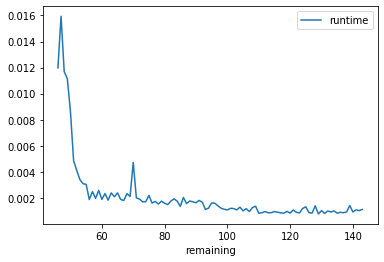

In [25]:
df2 = df[['remaining', 'runtime']].groupby('remaining')
df2.median().plot(kind='line')

In [26]:
df2.describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
46          319.0  0.012367  0.003397  0.004336  0.010931  0.011975  0.013495   
47            5.0  0.014496  0.008105  0.004061  0.008453  0.015938  0.020944   
48           36.0  0.012911  0.004747  0.004304  0.010423  0.011693  0.014822   
49           28.0  0.011004  0.003089  0.003811  0.009988  0.011140  0.012768   
50            3.0  0.007512  0.003453  0.003644  0.006126  0.008608  0.009446   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001416       NaN  0.001416  0.001416  0.001416  0.001416   
140           1.0  0.000924       NaN  0.000924  0.000924  0.000924  0.000924   
141           1.0  0.001080       NaN  0.001080  0.001080  0.001080  0.001080   
142           1.0  0.001027       NaN  0.001027  0.001027  0.001027  0.001027   
143           1.0  0.001115       NaN  0.001115  0.001115  0.001115  0.001115   

                     
                max  
remaining            
46         0.030560  
47         0.023082  
48         0.026605  
49         0.017137  
50         0.010284  
...             ...  
139        0.001416  
140        0.000924  
141        0.001080  
142        0.001027  
143        0.001115  

[98 rows x 8 columns]

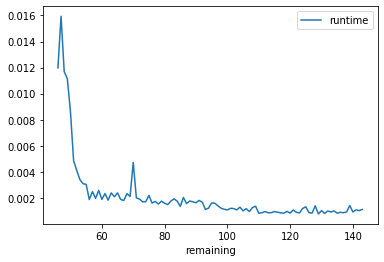

In [27]:
df2.median().plot(kind='line')

In [28]:
df2.describe()

runtime                                                              \
            count      mean       std       min       25%       50%       75%   
remaining                                                                       
46          319.0  0.012367  0.003397  0.004336  0.010931  0.011975  0.013495   
47            5.0  0.014496  0.008105  0.004061  0.008453  0.015938  0.020944   
48           36.0  0.012911  0.004747  0.004304  0.010423  0.011693  0.014822   
49           28.0  0.011004  0.003089  0.003811  0.009988  0.011140  0.012768   
50            3.0  0.007512  0.003453  0.003644  0.006126  0.008608  0.009446   
...           ...       ...       ...       ...       ...       ...       ...   
139           1.0  0.001416       NaN  0.001416  0.001416  0.001416  0.001416   
140           1.0  0.000924       NaN  0.000924  0.000924  0.000924  0.000924   
141           1.0  0.001080       NaN  0.001080  0.001080  0.001080  0.001080   
142           1.0  0.001027       NaN  0.001027  0.001027  0.001027  0.001027   
143           1.0  0.001115       NaN  0.001115  0.001115  0.001115  0.001115   

                     
                max  
remaining            
46         0.030560  
47         0.023082  
48         0.026605  
49         0.017137  
50         0.010284  
...             ...  
139        0.001416  
140        0.000924  
141        0.001080  
142        0.001027  
143        0.001115  

[98 rows x 8 columns]

In [29]:
tests = [
    {
        "size":8,
        "si":4,
        "sj":2,
        "clues":0
    },
    {
        "size":9,
        "si":3,
        "sj":3,
        "clues":0
    },
    {
        "size":10,
        "si":5,
        "sj":2,
        "clues":0
    },
    {
        "size":12,
        "si":4,
        "sj":3,
        "clues":0
    },
    {
        "size":12,
        "si":6,
        "sj":2,
        "clues":0
    },
    {
        "size":16,
        "si":4,
        "sj":4,
        "clues":0
    },
    {
        "size":16,
        "si":8,
        "sj":2,
        "clues":0
    },
    {
        "size":20,
        "si":5,
        "sj":4,
        "clues":0
    },
    {
        "size":20,
        "si":10,
        "sj":2,
        "clues":0
    },
    {
        "size":24,
        "si":6,
        "sj":4,
        "clues":0
    },
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    }
]

In [30]:
tests2 = [
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    }
]

In [31]:

def run(size, si, sj, clues, iterations=10):
    results = []
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        itestgrid = np.zeros((size, size))
        filling_start = time.time()
        fill_grid(itestgrid, si, sj)
        filling = time.time() - filling_start
        sparsing_start = time.time()
        o, g, stat = sparsify3(itestgrid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings': {
                'filling': filling,
                'sparsing': sparsing,
                'overall': time.time() - overall_start
            }
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time

In [32]:
# results, overall_time = run(**tests[0], iterations=10)

In [33]:
test_iterations = 10

for idx, test in enumerate(tests2):
    t = copy.deepcopy(test)
    results, overall_time = run(**t, iterations=test_iterations)
    t['results'] = results
    t['overall_time'] = overall_time
    t2 = np.array(t)
    np.save("test_{}_{}x{}_{}_of_{}.npy".format(t['size'], t['si'], t['sj'], idx, len(tests)), t2)




------------  TEST 1/10   SIZE=24 (8x3)   CLUE GOAL=144  ------------


KeyboardInterrupt: 

In [ ]:
def sparsify_test(filled_grid, si, sj, iterations=10):
#     Same grid but sparsifying it multiple times (randomization should give different results)
    size = si * sj
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    results = []
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  SPARSE TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        sparsing_start = time.time()
        o, g, stat = sparsify3(filled_grid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings': {
                'filling': 0.0,
                'sparsing': sparsing,
                'overall': time.time() - overall_start
            }
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time

In [6]:
def load(specific_filename="all_runs.npy"): # None for all .npy files
    data = {}
    for filename in os.listdir('.'):
        if not filename.endswith('.npy'):
            continue
        if specific_filename is not None and specific_filename != filename:
            continue
        raw_data = np.load(filename, allow_pickle=True).item()
        if specific_filename == "all_runs.npy":
            return raw_data
        if 'results' in raw_data and 'timings' in raw_data['results'][0]:
            for iteration, results in enumerate(raw_data['results']):
                raw_data['results'][iteration]['timings_filling'] = results['timings']['filling']
                raw_data['results'][iteration]['timings_sparsing'] = results['timings']['sparsing']
                raw_data['results'][iteration]['timings_overall'] = results['timings']['overall']
                del raw_data['results'][iteration]['timings']
        keyname = "{}_{}x{}".format(raw_data['size'], raw_data['si'], raw_data['sj'])
        data[keyname] = raw_data
    return data

In [ ]:
for iteration, results in enumerate(data['results']):
    grid = results['grid']
    sparsed = results['sparsed']
    stats = results['stats']
    
    o, g, stat = sparsify3(grid, si, sj, 0)
    

In [ ]:
data = load()

In [ ]:
data.keys()

In [ ]:
# np.save('all_runs.npy', data)

In [ ]:
# data['8_4x2']['results'][0].keys()

In [ ]:
# data['8_4x2'].keys()

In [ ]:
# data['8_4x2']['results'][0]['stats'][0].keys()

In [ ]:
# eight = [res['stats'] for res in data['8_4x2']['results']][0]

all_tests_stats = []
for gsize in data.keys():
    for testnum, result in enumerate(data[gsize]['results']):
        for statnum, stat in enumerate(result['stats']):
            data[gsize]['results'][testnum]['stats'][statnum]['gsize'] = gsize
            data[gsize]['results'][testnum]['stats'][statnum]['testnum'] = testnum
        all_tests_stats.extend(data[gsize]['results'][testnum]['stats'])
df = pd.DataFrame(all_tests_stats)

# Remove outliers
df = df[(df.gsize != '20_5x4') | (df.testnum != 3)]
df = df[(df.gsize != '20_10x2') | (df.testnum != 1)]
# for i, res in enumerate(data['8_4x2']['results']):
#     for r in res['stats']:
#         r2 = r
#         r2['test'] = i
#         eight.append(r2)
#     eight.append(iteration)
#     eight = [res['stats'] for res in data['8_4x2']['results']]

In [14]:
df.describe()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,testnum
count,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000,73690.000000
mean,73.367485,1246.583526,623.291763,131.073755,7.870227,7.812905,8.811752,1.845895,0.913285,4.500000
std,28.881638,575.026923,489.822130,67.699516,5.265565,5.273074,5.269306,0.361052,1.632319,2.872301
min,16.000000,181.000000,0.000000,18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,64.000000,1024.000000,207.000000,91.000000,3.000000,3.000000,4.000000,2.000000,0.016008,2.000000
50%,64.000000,1024.000000,490.000000,155.000000,7.000000,7.000000,8.000000,2.000000,0.172994,4.500000
75%,100.000000,1788.000000,946.000000,173.000000,12.000000,12.000000,13.000000,2.000000,1.344704,7.000000
max,100.000000,1788.000000,1788.000000,399.000000,19.000000,19.000000,20.000000,2.000000,50.937691,9.000000


In [15]:
df.head()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
0,16,181,0,63,1,2,1.0,1,0.001999,8_4x2,0
1,16,181,1,62,3,4,5.0,1,0.001005,8_4x2,0
2,16,181,2,61,7,1,3.0,1,0.000999,8_4x2,0
3,16,181,3,60,7,5,5.0,1,0.000999,8_4x2,0
4,16,181,4,59,2,0,5.0,1,0.001001,8_4x2,0


In [109]:
def print_indiv_stats(df, gsize):
    print("\n\n\n\n")
    print(gsize)
    print("\n\n")
    gframe = df[df.gsize == gsize]
    row_cnt = gframe.count() + 1
    tests = list(set(gframe['testnum'].tolist()))
    
    desc = gframe[['remaining', 'runtime']].describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    display(desc)
    
    print("\n\nslowest runtimes:")
    display(gframe.sort_values(by=['runtime'], ascending=False).head())
    
    print("\n\nfastest runtimes:")
    display(gframe.sort_values(by=['runtime'], ascending=True).head())
    
    numbers = gframe['sol_cnt'].value_counts().tolist()
    percents = gframe['sol_cnt'].value_counts(normalize=True).tolist()
    print("\nCell removal gave 1 unique solution:   {} or {:.2f}%".format(numbers[1], 100*percents[1]))
    print("Cell removal gave 2+ solutions:        {} or {:.2f}%".format(numbers[0], 100*percents[0]))
    
    print("\n\nDistribution of Successfully removed values:")
    display(gframe[gframe.sol_cnt==1]['orig_val'].value_counts(normalize=True))
    
    print("\n\nDistribution of Incorrectly removed values:")
    display(gframe[gframe.sol_cnt==2]['orig_val'].value_counts(normalize=True))
    

In [ ]:
# def overall_stats(df):
#     remaining_count_runtime = df.groupby(['remaining'])['remaining', 'runtime'].agg(
#         {'remaining':'count', 'runtime':'mean'}).rename(
#             columns={'remaining_count':'count', 'runtime':'runtime_mean'})
    

In [ ]:
# gframe['sol_cnt'].value_counts(normalize=True)
# remaining_count_runtime = df.groupby(['remaining'])['remaining', 'runtime'].agg({'remaining':'count',
#                                                        'runtime':'mean'}).rename(columns={'remaining':'remaining_count',
#                                                        'runtime':'runtime_mean'})
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     display(remaining_count_runtime)
# remaining_count_runtime.plot()

In [ ]:
# df[df.gsize=='16_4x4' & df.sol_cnt==1]['orig_val'].value_counts()

# gframe[['orig_val','sol_cnt']].count_values()
# gframe.iloc[gframe['runtime'].idxmax()]


In [ ]:
print_indiv_stats(df, '8_4x2')

In [ ]:
for gsize in set(df['gsize'].tolist()):
    print_indiv_stats(df, gsize)
    
    gframe = df[df.gsize == gsize]
    
    remaining_count_runtime = gframe.groupby(['remaining'])['remaining', 'runtime'].agg({'remaining':'count',
                                                       'runtime':'mean'}).rename(columns={'remaining':'remaining_count',
                                                       'runtime':'runtime_mean'})
    remaining_count_runtime.plot()

    
    fig, ax = plt.subplots(figsize=(12,12))
    for key, grp in gframe.groupby('testnum'):
        ax = grp.plot(ax=ax, kind='line', x='remaining', y='runtime', label=f"{gsize} #{key}")
        ax.invert_xaxis()
        ax.set_ylabel('solving runtime')
        ax.set_xlabel('clues')
#     plt.show()

    # df = df[['remaining', 'runtime']].groupby('remaining')
    # df.median().plot(kind='line')

#     fig2, ax2 = plt.subplots(figsize=(12,12))
    # ax2 = df[['remaining', 'runtime']].groupby('remaining').median().plot(kind='line')
    ax2 = gframe.groupby(['remaining'])[['runtime']].mean().plot(kind='line', y='runtime', label=f"{gsize} average")
    ax2.set_ylabel('solving runtime')
    ax2.set_xlabel('clues')
    ax2.invert_xaxis()
    plt.show()
    


In [620]:
def load_all():

    pd_data = {
        "point": [],
        "puzzle": [],
        "identical": [],
        "clues": [],
        "bin_time": [],
        "lin_time": []
    }
    
    array = np.load(file='all_runs.npy', allow_pickle=True)
    results = array.item()

    for item in results.items():

        name = item[0]
        data = item[1]

        si = data['si']
        sj = data['sj']

        iterations = data['results']

        total_bin_time = 0
        bin_count = 0
        total_lin_time = 0
        lin_count = 0 

        for i, iteration in enumerate(iterations):
            
            grid = iteration['sparsed']
            clues = iteration['clue_count']

            model = None
            model2 = None
            
            pd_data['puzzle'].append(name)
            pd_data['clues'].append(clues)
            pd_data['point'].append(i)

            # If dimensions are equal, use the original solver.
            if si == sj:
                model, var = gurobi_solution(grid)
                # Now, check the solution when we don't use binary variables.
                model2, var2 = gurobi_solution(grid, binary=False)


                total_bin_time += model.RunTime
                bin_count += 1

                pd_data['bin_time'].append(model.RunTime)
                
                if model.getAttr('X', var) == model2.getAttr('X', var2):
                    print('Equal    : %s %i: bin %.5f lin %.5f delta %.5f clues %s' % (name, i, model.RunTime, model2.RunTime, model.RunTime - model2.RunTime, clues))
#                     print(model.getAttr('X', var))
#                     print(model2.getAttr('X', var2))
                    total_lin_time += model2.RunTime
                    lin_count += 1
                    
                    pd_data['identical'].append(1.0)
                    pd_data['lin_time'].append(model2.RunTime)
                    
                    print("Binary Solution: ")
                    print_solution(grid, model, var)
                    print("Linear Relaxation Solution: ")
                    print_solution(grid, model2, var2)
                else:
                    print("Not Equal: %s %i: bin %.5f %s" % (name, i, model.RunTime, clues))
                    pd_data['identical'].append(0.0)
                    pd_data['lin_time'].append(np.NaN)

            else:

                model, var, sols, sol_count = gurobi_solution2(grid, si, sj)
                # print_solution2(grid, model, var, si, sj)
                model2, var2, sols2, sol_count2 = gurobi_solution2(grid, si, sj, binary=False)
                # print_solution2(grid, model2, var2, si, sj)

                total_bin_time += model.RunTime
                bin_count += 1
                
                pd_data['bin_time'].append(model.RunTime)

                if model.getAttr('X', var) == model2.getAttr('X', var2):
                    print('Equal    : %s %i: bin %.5f lin %.5f delta %.5f clues %s' % (name, i, model.RunTime, model2.RunTime, model.RunTime - model2.RunTime, clues))
                    total_lin_time += model2.RunTime
                    lin_count += 1
                    
                    pd_data['identical'].append(1.0)
                    pd_data['lin_time'].append(model2.RunTime)
                    
                    print("Binary Solution: ")
#                     print_solution2(grid, model, var, si, sj)
                    print("Linear Relaxation Solution: ")
#                     print_solution2(grid, model2, var2, si, sj)
                else:
                    print("Not Equal: %s %i: bin %.5f %s" % (name, i, model.RunTime, clues))
                    pd_data['identical'].append(0.0)
                    pd_data['lin_time'].append(np.NaN)
#                     print(model.getAttr('X', var))
#                     print(model2.getAttr('X', var2))



            # print('%s %i: %.5f %.5f %.5f' % (result, i, model.RunTime, model2.RunTime, model.RunTime - model2.RunTime))

        average_bin_time = total_bin_time / bin_count if bin_count > 0 else 0
        average_lin_time = total_lin_time / lin_count if lin_count > 0 else 0


        
        print("TOTAL: solved %s of %s bin %.5f lin %.5f delta %.5f" % (bin_count, len(iterations), average_bin_time, average_lin_time, average_bin_time - average_lin_time))

    return pd_data

In [621]:
data_dict = load_all()

Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 256 rows, 512 columns and 2048 nonzeros
Model fingerprint: 0x6fec8d11
Variable types: 0 continuous, 512 integer (512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 256 rows and 512 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 256 rows, 512 columns and 2048 nonzeros
Model fingerprint: 0x09518940
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range   

Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 250 rows and 506 columns
Presolve time: 0.00s
Presolved: 6 rows, 6 columns, 16 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+00   0.000000e+00      0s
       2    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Equal    : 8_4x2 5: bin 0.00964 lin 0.00907 delta 0.00058 clues 20
Binary Solution: 
Linear Relaxation Solution: 
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 256 rows, 512 columns and 2048 nonzeros
Model fingerprint: 0x147c9296
Variable types: 0 continuous, 512 integer (512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+0

Not Equal: 9_3x3 6: bin 0.00133 24
Equal    : 9_3x3 7: bin 0.00169 lin 0.00054 delta 0.00115 clues 22
Binary Solution: 

Solution:

712  694  385
936  815  472
854  273  169

425  987  631
683  521  794
197  346  528

349  758  216
568  132  947
271  469  853
Linear Relaxation Solution: 

Solution:

712  694  385
936  815  472
854  273  169

425  987  631
683  521  794
197  346  528

349  758  216
568  132  947
271  469  853
Equal    : 9_3x3 8: bin 0.00154 lin 0.00083 delta 0.00071 clues 25
Binary Solution: 

Solution:

325  694  187
187  253  694
469  817  253

614  725  839
972  138  546
853  469  721

731  542  968
546  981  372
298  376  415
Linear Relaxation Solution: 

Solution:

325  694  187
187  253  694
469  817  253

614  725  839
972  138  546
853  469  721

731  542  968
546  981  372
298  376  415
Equal    : 9_3x3 9: bin 0.00154 lin 0.00054 delta 0.00100 clues 24
Binary Solution: 

Solution:

862  349  175
974  581  236
513  267  948

621  798  453
458  632  719
397  415 

       0    0.0000000e+00   2.600000e+01   0.000000e+00      0s
      51    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
Not Equal: 10_5x2 4: bin 0.01312 34
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 400 rows, 1000 columns and 4000 nonzeros
Model fingerprint: 0x4d3d7e9e
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 400 rows and 1000 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.

Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0x403df828
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 440 rows and 1517 columns
Presolve time: 0.01s
Presolved: 136 rows, 211 columns, 653 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.200000e+01   0.000000e+00      0s
     128    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 128 iterations and 0.02 seconds
Optimal objective  0.000000000e+00
Not Equal: 12_4x3 0: bin 0.03075 47
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 r

Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0x9736422b
Variable types: 0 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 576 rows and 1728 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0xd709bc0f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 405 rows and 

  RHS range        [1e+00, 1e+00]
Presolve removed 418 rows and 1481 columns
Presolve time: 0.01s
Presolved: 158 rows, 247 columns, 752 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.300000e+01   0.000000e+00      0s
     113    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 113 iterations and 0.04 seconds
Optimal objective  0.000000000e+00
Not Equal: 12_6x2 1: bin 0.01349 50
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0x3f3e6f04
Variable types: 0 continuous, 1728 integer (1728 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 576 rows and 1728 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 

Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 576 rows, 1728 columns and 6912 nonzeros
Model fingerprint: 0x06eca40a
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 466 rows and 1570 columns
Presolve time: 0.01s
Presolved: 110 rows, 158 columns, 480 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.049800e+01   0.000000e+00      0s
     115    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 115 iterations and 0.01 seconds
Optimal objective  0.000000000e+00
N

H    0     0                       0.0000000    0.00000  0.00%     -    0s
     0     0    0.00000    0  283    0.00000    0.00000  0.00%     -    0s

Cutting planes:
  Gomory: 2
  Clique: 97
  Zero half: 18

Explored 1 nodes (1078 simplex iterations) in 0.14 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1024 rows, 4096 columns and 16384 nonzeros
Model fingerprint: 0x64c0a17f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 707 rows and 3571 columns
Presolve time: 0.01s
Presolved: 317 rows, 525 columns, 1612 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.500000e+01   0.000000e+

       0    0.0000000e+00   6.900000e+01   0.000000e+00      0s
     406    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 406 iterations and 0.02 seconds
Optimal objective  0.000000000e+00
Not Equal: 16_8x2 7: bin 0.02744 101
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1024 rows, 4096 columns and 16384 nonzeros
Model fingerprint: 0xf4e6b3ac
Variable types: 0 continuous, 4096 integer (4096 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 718 rows and 3766 columns
Presolve time: 0.04s
Presolved: 306 rows, 330 columns, 1324 nonzeros
Variable types: 0 continuous, 330 integer (330 binary)

Root relaxation: objective 0.000000e+00, 357 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



     0     0    0.00000    0  418          -    0.00000      -     -    0s
     0     0    0.00000    0  472          -    0.00000      -     -    0s
     0     0    0.00000    0  505          -    0.00000      -     -    1s
     0     0    0.00000    0  516          -    0.00000      -     -    1s
     0     0    0.00000    0  514          -    0.00000      -     -    1s
     0     2    0.00000    0  514          -    0.00000      -     -    1s
*  918    20              12       0.0000000    0.00000  0.00%   101    3s

Cutting planes:
  Cover: 1
  Clique: 1
  Zero half: 4

Explored 939 nodes (103554 simplex iterations) in 3.60 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1600 rows, 8000 columns and 32000 nonzeros
Model fingerprint: 0x6374c52b
Coefficient st


Cutting planes:
  Cover: 5
  Clique: 6
  Zero half: 3

Explored 1903 nodes (168616 simplex iterations) in 6.13 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1600 rows, 8000 columns and 32000 nonzeros
Model fingerprint: 0x0b3a7dd2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 1031 rows and 6983 columns
Presolve time: 0.02s
Presolved: 569 rows, 1017 columns, 3240 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.356e+03
 Factor NZ  : 4.462e+04 (roughly 1 MByte of memory)
 Factor Ops : 6.234e+06 (less than 1 second per iteration)
 Threa

Optimize a model with 1600 rows, 8000 columns and 32000 nonzeros
Model fingerprint: 0x2b178938
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 1039 rows and 7043 columns
Presolve time: 0.02s
Presolved: 561 rows, 957 columns, 3023 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.093e+03
 Factor NZ  : 3.776e+04 (roughly 1 MByte of memory)
 Factor Ops : 4.715e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  1.11e+01 0.00e+00  9.08e-02     0s
   1   0.00000000e+00 -8.87164024e+00  1.95e+00 0.00e+00  1.86e-02     0s
   2   0.00000000e+00 -2.68400168e+00  3.80e-01 0.00e+00  3.90e-03     0s
   3   0.

   0   0.00000000e+00  0.00000000e+00  1.09e+01 0.00e+00  9.47e-02     0s
   1   0.00000000e+00 -9.73127049e+00  1.76e+00 0.00e+00  1.86e-02     0s
   2   0.00000000e+00 -2.65925290e+00  3.14e-01 0.00e+00  3.47e-03     0s
   3   0.00000000e+00 -4.27110449e-01  2.70e-02 0.00e+00  4.33e-04     0s
   4   0.00000000e+00 -4.25378104e-03  3.89e-04 6.25e-17  4.23e-06     0s
   5   0.00000000e+00 -4.25043651e-06  2.25e-08 5.55e-17  3.89e-09     0s
   6   0.00000000e+00 -4.25043445e-09  1.19e-11 8.33e-17  3.88e-12     0s

Barrier solved model in 6 iterations and 0.05 seconds
Optimal objective 0.00000000e+00

Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 0s

     424 PPushes remaining with PInf 0.0000000e+00                 0s
       0 PPushes remaining with PInf 0.0000000e+00                 0s

  Push phase complete: Pinf 0.0000000e+00, Dinf 0.0000000e+00      0s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
     451    0.0000000e+00   


Iteration    Objective       Primal Inf.    Dual Inf.      Time
     475    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved with barrier
Solved in 475 iterations and 0.08 seconds
Optimal objective  0.000000000e+00
Not Equal: 20_5x4 9: bin 1.73855 162
TOTAL: solved 10 of 10 bin 2.57697 lin 0.00000 delta 2.57697
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1600 rows, 8000 columns and 32000 nonzeros
Model fingerprint: 0x82f9a879
Variable types: 0 continuous, 8000 integer (8000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1055 rows and 7259 columns
Presolve time: 0.03s
Presolved: 545 rows, 741 columns, 2782 nonzeros
Variable types: 0 continuous, 741 integer (741 binary)

Root relaxation: objective 0.000000e+00, 806 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     

Presolved: 615 rows, 858 columns, 3211 nonzeros
Variable types: 0 continuous, 858 integer (858 binary)

Root relaxation: objective 0.000000e+00, 977 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  431          -    0.00000      -     -    0s
     0     0    0.00000    0  450          -    0.00000      -     -    0s
     0     0    0.00000    0  397          -    0.00000      -     -    0s
     0     0    0.00000    0  449          -    0.00000      -     -    0s
     0     0    0.00000    0  437          -    0.00000      -     -    0s
     0     0    0.00000    0  407          -    0.00000      -     -    0s
     0     0    0.00000    0  407          -    0.00000      -     -    0s
     0     2    0.00000    0  407          -    0.00000      -     -    1s
*  155    26              14       0.0000000    0.00000  0.00%  76.1    1s

Presolved: 494 rows, 851 columns, 2565 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.544e+03
 Factor NZ  : 3.203e+04 (roughly 1 MByte of memory)
 Factor Ops : 3.733e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00 -1.00000000e-01  1.21e+01 0.00e+00  9.87e-02     0s
   1   0.00000000e+00 -8.79118624e+00  2.07e+00 0.00e+00  2.02e-02     0s
   2   0.00000000e+00 -2.62071278e+00  4.66e-01 0.00e+00  4.30e-03     0s
   3   0.00000000e+00 -6.64586234e-01  9.70e-02 0.00e+00  9.33e-04     0s
   4   0.00000000e+00 -5.77663292e-02  9.96e-03 0.00e+00  7.42e-05     0s
   5   0.00000000e+00 -7.00958141e-05  5.29e-05 1.11e-16  1.23e-07     0s
   6   0.00000000e+00 -7.00904651e-08  2.75e-08 5.55e-17  1.02e-10     0s
   7   0.00000000e+00 -9.52190723e-14  4.53e-14 7.88e-17  1.45e-16     0s

Barrier solved model in 7 iterations a


      10 DPushes remaining with DInf 0.0000000e+00                 0s
       0 DPushes remaining with DInf 0.0000000e+00                 0s

     348 PPushes remaining with PInf 0.0000000e+00                 0s

Solved with dual simplex
Solved in 584 iterations and 0.05 seconds
Optimal objective  0.000000000e+00
Not Equal: 20_10x2 6: bin 0.44697 177
Gurobi Optimizer version 9.0.0 build v9.0.0rc2 (mac64)
Optimize a model with 1600 rows, 8000 columns and 32000 nonzeros
Model fingerprint: 0x820dd0f6
Variable types: 0 continuous, 8000 integer (8000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 1183 rows and 7449 columns
Presolve time: 0.03s
Presolved: 417 rows, 551 columns, 2090 nonzeros
Variable types: 0 continuous, 551 integer (551 binary)

Root relaxation: objective 0.000000e+00, 577 iterations, 0.01 seconds

    Nodes    |    Current Node    |     

 Factor Ops : 4.674e+06 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   0.00000000e+00  0.00000000e+00  1.18e+01 0.00e+00  1.02e-01     0s
   1   0.00000000e+00 -9.42565557e+00  1.63e+00 0.00e+00  1.85e-02     0s
   2   0.00000000e+00 -2.82339753e+00  4.38e-01 0.00e+00  4.46e-03     0s
   3   0.00000000e+00 -7.21499069e-01  4.94e-02 0.00e+00  8.56e-04     0s
   4   0.00000000e+00 -2.71474153e-02  7.64e-03 0.00e+00  3.46e-05     0s
   5   0.00000000e+00 -7.48435664e-05  4.93e-05 5.55e-17  1.16e-07     0s
   6   0.00000000e+00 -7.48300010e-08  1.19e-08 5.55e-17  8.62e-11     0s
   7   0.00000000e+00 -2.85038067e-13  1.34e-12 5.55e-17  3.44e-16     0s

Barrier solved model in 7 iterations and 0.06 seconds
Optimal objective 0.00000000e+00

Crossover log...

       0 DPushes remaining with DInf 0.0000000e+00                 0s

     395 PPushes remaining w

In [622]:
import pandas as pd
df = pd.DataFrame(data_dict) 
df.groupby('puzzle').count()

# Get total identical solutions found by both the integer and linear algorithms.
df[df['identical'] == 1.0].groupby('puzzle').count()['identical'].sort_values()

puzzle
12_4x3     1
12_6x2     3
10_5x2     5
9_3x3      7
8_4x2     10
Name: identical, dtype: int64

In [623]:
df.describe()

,point,identical,clues,bin_time,lin_time
count,90.000000,90.000000,90.000000,90.000000,26.000000
mean,4.500000,0.288889,78.822222,0.392865,0.008393
std,2.888373,0.455785,55.020850,0.997626,0.005702
min,0.000000,0.000000,19.000000,0.001091,0.000526
25%,2.000000,0.000000,33.000000,0.012125,0.002933
50%,4.500000,0.000000,52.000000,0.015404,0.009120
75%,7.000000,1.000000,103.000000,0.078606,0.011690
max,9.000000,1.000000,180.000000,6.131706,0.019663


In [624]:
# Get average time solved for binary and linear solution.
df['identical_count'] = df['identical'] * 10
df3 = df.groupby('puzzle').mean()[['bin_time', 'lin_time', 'identical_count']].sort_values(by='identical_count', ascending=False)
df3['delta'] = df3.bin_time - df3.lin_time

df3

,bin_time,lin_time,identical_count,delta
puzzle,,,,
8_4x2,0.012494,0.009142,10.0,0.003352
9_3x3,0.001553,0.000784,7.0,0.000769
10_5x2,0.020979,0.015398,5.0,0.005581
12_6x2,0.020602,0.011131,3.0,0.009471
12_4x3,0.016447,0.010926,1.0,0.005521
16_4x4,0.035201,NaN,0.0,NaN
16_8x2,0.046187,NaN,0.0,NaN
20_10x2,0.805354,NaN,0.0,NaN
20_5x4,2.576966,NaN,0.0,NaN


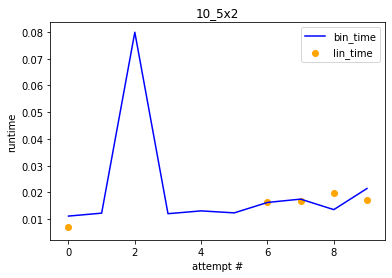

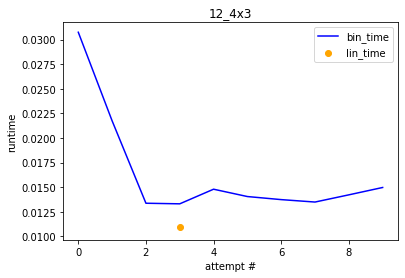

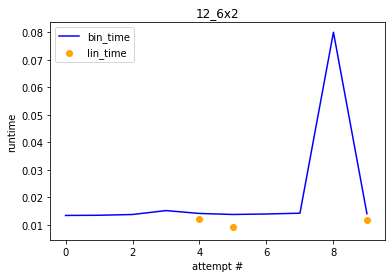

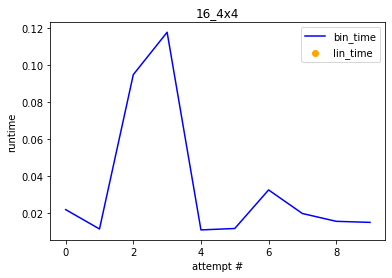

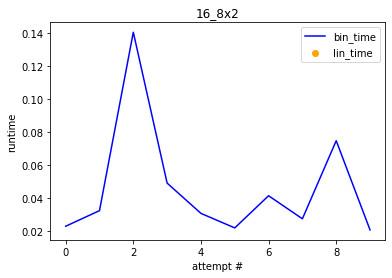

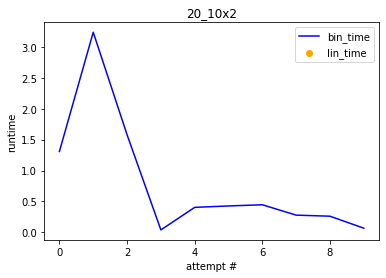

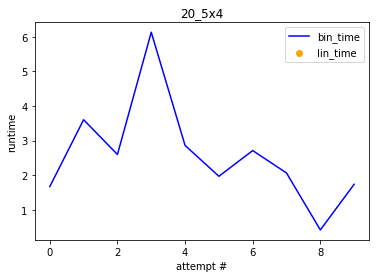

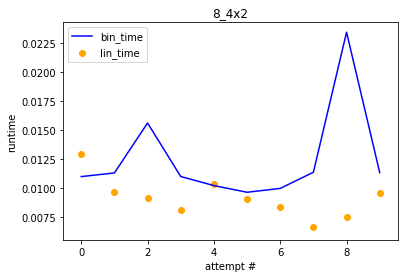

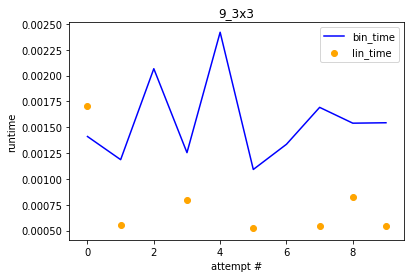

In [625]:
import matplotlib.pyplot as plt

def plot_grid_results(key, df):

    if df[df.identical == 1.0].count != 0:

        index = np.arange(10)
        spacing = .60

        pdf = df[df['puzzle'] == key][['bin_time', 'lin_time', 'point']]
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(pdf['point'], pdf['bin_time'], label='bin_time', color='blue', alpha=1.0)
        ax.scatter(pdf['point'], pdf['lin_time'], label='lin_time', color='orange', alpha=1.0)
        ax.set_title(key)
        ax.set_xlabel('attempt #')
        ax.set_ylabel('runtime')
        ax.legend(loc='best')
        ax.plot()
            

df2 = df[['lin_time', 'bin_time', 'puzzle']].groupby('puzzle')

# for key, grp in gframe.groupby('testnum'):
for key, group in df[['lin_time', 'bin_time', 'puzzle', 'point', 'identical']].groupby('puzzle'):
    plot_grid_results(key, group)